In [2]:
# import things
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

In [3]:
# REQUIREMENT: Do not add code from Tasks 2 or 4
# REQUIREMENT: All dataset prep (crop/pad/patch/directory structure) must be finalize before attempting this task.
patch_size = 256
patch_dir = r"C:\Users\batkm\Desktop\Year2BlockB\Datasets\combined_patched_dataset_v4"


In [4]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
# Define U-Net
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])
    model.summary()
    
    return model

In [6]:
# Build U-Net
# REQUIREMENT: Model summary must be visible
model = simple_unet_model(patch_size, patch_size, 3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [6]:
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='rgb',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

Found 116424 images belonging to 1 classes.
Found 116424 images belonging to 1 classes.


In [7]:
# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='rgb',
    seed=42
)

# Training masks
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)

Found 22050 images belonging to 1 classes.
Found 22050 images belonging to 1 classes.


In [8]:
# EarlyStopping()
from keras.callbacks import EarlyStopping
cb = EarlyStopping(monitor='val_f1', patience=5)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Device: ", tf.test.gpu_device_name())


Num GPUs Available:  1
GPU Device:  /device:GPU:0


In [10]:
# This is where the magic happens
# REQUIREMENT: The epoch logs must be visible showing validation loss and validation f1.
with tf.device('GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_image_generator),
        validation_data=val_generator,
        validation_steps=len(val_image_generator),
        epochs=50,
        callbacks=[cb],
        verbose=1
    )
 

Epoch 1/50
3639/3639 [==============================] - 853s 232ms/step - loss: 0.0156 - f1: 0.4391 - val_loss: 0.0050 - val_f1: 0.7357
Epoch 2/50
3639/3639 [==============================] - 833s 229ms/step - loss: 0.0050 - f1: 0.7579 - val_loss: 0.0048 - val_f1: 0.7509
Epoch 3/50
3639/3639 [==============================] - 786s 216ms/step - loss: 0.0043 - f1: 0.7846 - val_loss: 0.0041 - val_f1: 0.8022
Epoch 4/50
3639/3639 [==============================] - 785s 216ms/step - loss: 0.0040 - f1: 0.7982 - val_loss: 0.0035 - val_f1: 0.8132
Epoch 5/50
3639/3639 [==============================] - 785s 216ms/step - loss: 0.0038 - f1: 0.8101 - val_loss: 0.0040 - val_f1: 0.8131
Epoch 6/50
3639/3639 [==============================] - 787s 216ms/step - loss: 0.0037 - f1: 0.8152 - val_loss: 0.0035 - val_f1: 0.8218


In [15]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
example_file_name = f'michal_232079_unet_model_v4_{patch_size}px.h5'
print(example_file_name)
model.save(example_file_name)

michal_232079_unet_model_v3_256px.h5


In [16]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.003515792777761817
Best validation f1: 0.8218124508857727


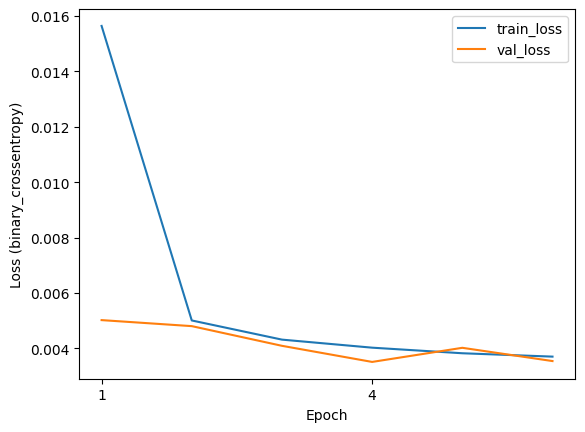

In [18]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

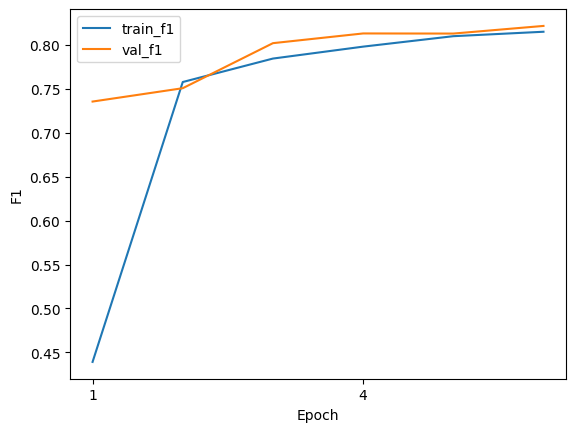

In [19]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))